In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


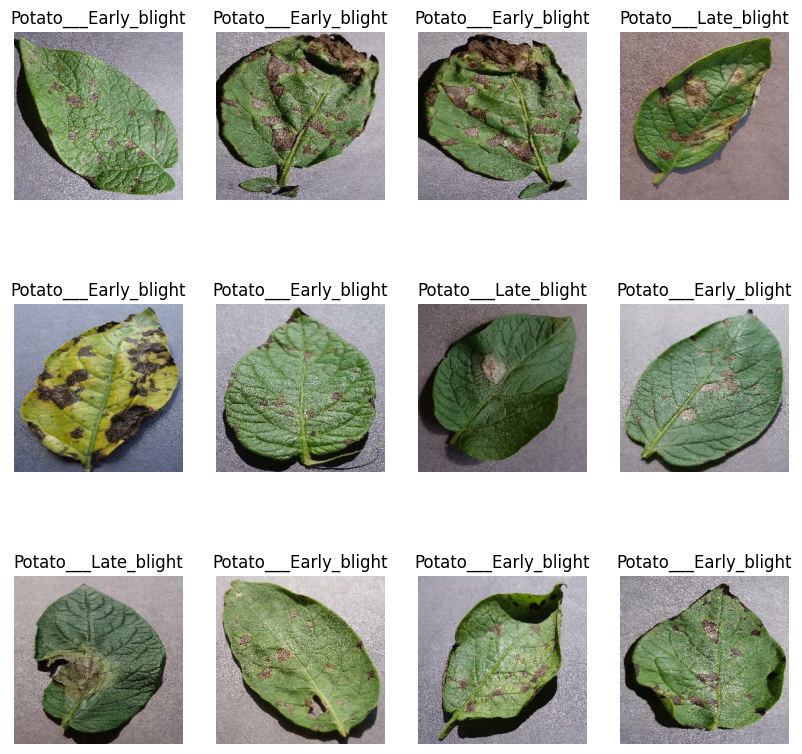

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [20]:
from tensorflow.keras import layers, models
n_classes = 3
# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Build the custom CNN model
model = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten layer
    layers.Flatten(),

    # Dense Block
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(n_classes, activation='softmax')
])

# Display model summary
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                     

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 98s 1s/step - loss: 4.6066 - accuracy: 0.8449 - val_loss: 272.1418 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 79s 1s/step - loss: 0.7134 - accuracy: 0.8744 - val_loss: 124.4491 - val_accuracy: 0.4896
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.4527 - accuracy: 0.8935 - val_loss: 43.5712 - val_accuracy: 0.5260
Epoch 4/50
54/54 [==============================] - 81s 1s/step - loss: 0.3690 - accuracy: 0.8953 - val_loss: 4.4059 - val_accuracy: 0.6875
Epoch 5/50
54/54 [==============================] - 81s 1s/step - loss: 0.4135 - accuracy: 0.9144 - val_loss: 7.2683 - val_accuracy: 0.5104
Epoch 6/50
54/54 [==============================] - 81s 1s/step - loss: 0.3258 - accuracy: 0.9201 - val_loss: 4.1297 - val_accuracy: 0.6771
Epoch 7/50
54/54 [==============================] - 82s 2s/step - loss: 0.2578 - accuracy: 0.9225 - val_loss: 1.5962 - val_accuracy: 0.8490
Epoch 8/50
54

In [24]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 314ms/step - loss: 5.3505 - accuracy: 0.6562


In [25]:
scores

[5.350536346435547, 0.65625]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

50

In [31]:
len(history.history['loss'])

50

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[4.606564044952393,
 0.7134121060371399,
 0.4527292847633362,
 0.36904793977737427,
 0.41347718238830566]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [133]:
print(acc)

[0.8449074029922485, 0.8744212985038757, 0.8935185074806213, 0.8952546119689941, 0.9143518805503845, 0.9201388955116272, 0.9224537014961243, 0.9241898059844971, 0.9363425970077515, 0.9450231194496155, 0.9178240895271301, 0.9357638955116272, 0.9537037014961243, 0.9351851940155029, 0.9386574029922485, 0.9519675970077515, 0.9554398059844971, 0.9288194179534912, 0.9178240895271301, 0.9317129850387573, 0.9409722089767456, 0.9195601940155029, 0.9461805820465088, 0.9403935074806213, 0.9438657164573669, 0.9438657164573669, 0.9380787014961243, 0.9236111044883728, 0.9288194179534912, 0.9450231194496155, 0.9473379850387573, 0.9519675970077515, 0.9456018805503845, 0.9415509104728699, 0.9427083134651184, 0.9409722089767456, 0.9288194179534912, 0.9461805820465088, 0.9513888955116272, 0.9473379850387573, 0.9502314925193787, 0.9612268805503845, 0.9623842835426331, 0.9542824029922485, 0.9346064925193787, 0.9450231194496155, 0.9490740895271301, 0.9467592835426331, 0.9432870149612427, 0.9467592835426331]

In [135]:
print(len(acc))

50


In [136]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [139]:
nacc=moving_average(acc,5)

In [140]:
print(nacc)

[0.88449074 0.89953704 0.90914352 0.91527778 0.92349538 0.92962962
 0.92916666 0.9318287  0.93773148 0.9375     0.93622686 0.94305556
 0.94699074 0.94201388 0.93854166 0.93715278 0.9349537  0.92777778
 0.93125001 0.9357639  0.93819444 0.93877314 0.94247684 0.93796295
 0.93564813 0.93587961 0.93657407 0.93935184 0.94375    0.9462963
 0.94583334 0.94456018 0.93993055 0.94004629 0.94201388 0.94293982
 0.94479167 0.95127317 0.95451391 0.95509261 0.95254631 0.95150464
 0.94907408 0.94594908 0.94375    0.94618056]


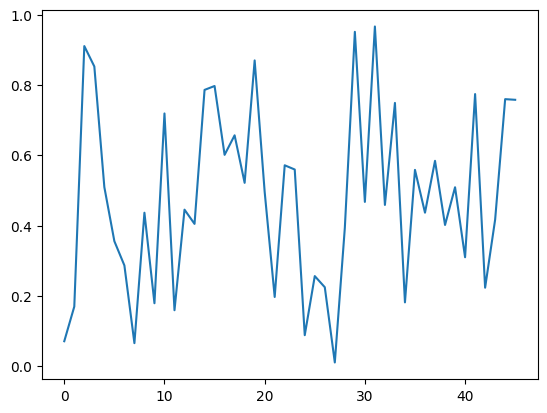

In [150]:
plt.plot(nacc)

ValueError: x and y must have same first dimension, but have shapes (50,) and (46,)

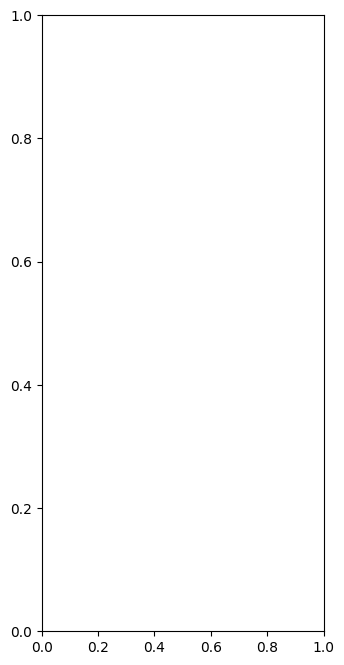

In [143]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [114]:
labels = []
predictions = []
for x,y in test_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 349ms/step


In [123]:
import numpy as np
import itertools

# Example predictions (replace this with your actual predictions)
predictions = np.array([1, 2, 3, 4])

# Now, you can use itertools to flatten the 1D array
flat_predictions = list(itertools.chain.from_iterable(predictions))

# Print the flattened predictions
print(flat_predictions)


TypeError: 'numpy.int32' object is not iterable

In [43]:
pip install matplotlib scikit-learn

     ---------------------------------------- 9.3/9.3 MB 8.0 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 KB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [34]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 337ms/step
predicted label: Potato___healthy


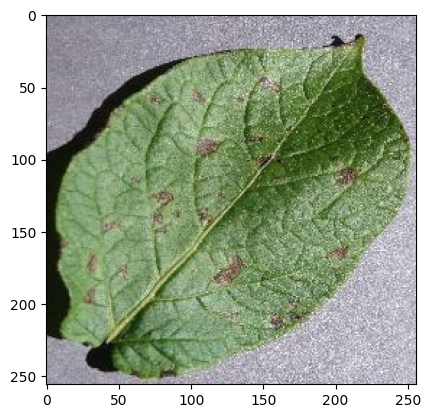

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [131]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    idx=0
    for x in predictions:
        for y in x:
            print(class_names[idx],round(y*100,2))
            idx+=1
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step
Potato___Early_blight 100.0
Potato___Late_blight 0.0
Potato___healthy 0.0
1/1 [==============================] - 0s 34ms/step
Potato___Early_blight 0.0
Potato___Late_blight 100.0
Potato___healthy 0.0
1/1 [==============================] - 0s 36ms/step
Potato___Early_blight 99.77
Potato___Late_blight 0.23
Potato___healthy 0.0
1/1 [==============================] - 0s 40ms/step
Potato___Early_blight 100.0
Potato___Late_blight 0.0
Potato___healthy 0.0
1/1 [==============================] - 0s 38ms/step
Potato___Early_blight 0.0
Potato___Late_blight 0.0
Potato___healthy 100.0
1/1 [==============================] - 0s 37ms/step
Potato___Early_blight 100.0
Potato___Late_blight 0.0
Potato___healthy 0.0
1/1 [==============================] - 0s 37ms/step
Potato___Early_blight 0.0
Potato___Late_blight 0.0
Potato___healthy 100.0
1/1 [==============================] - 0s 46ms/step
Potato___Early_blight 0.0
Potato___Late_blight 3.65
Potato___heal

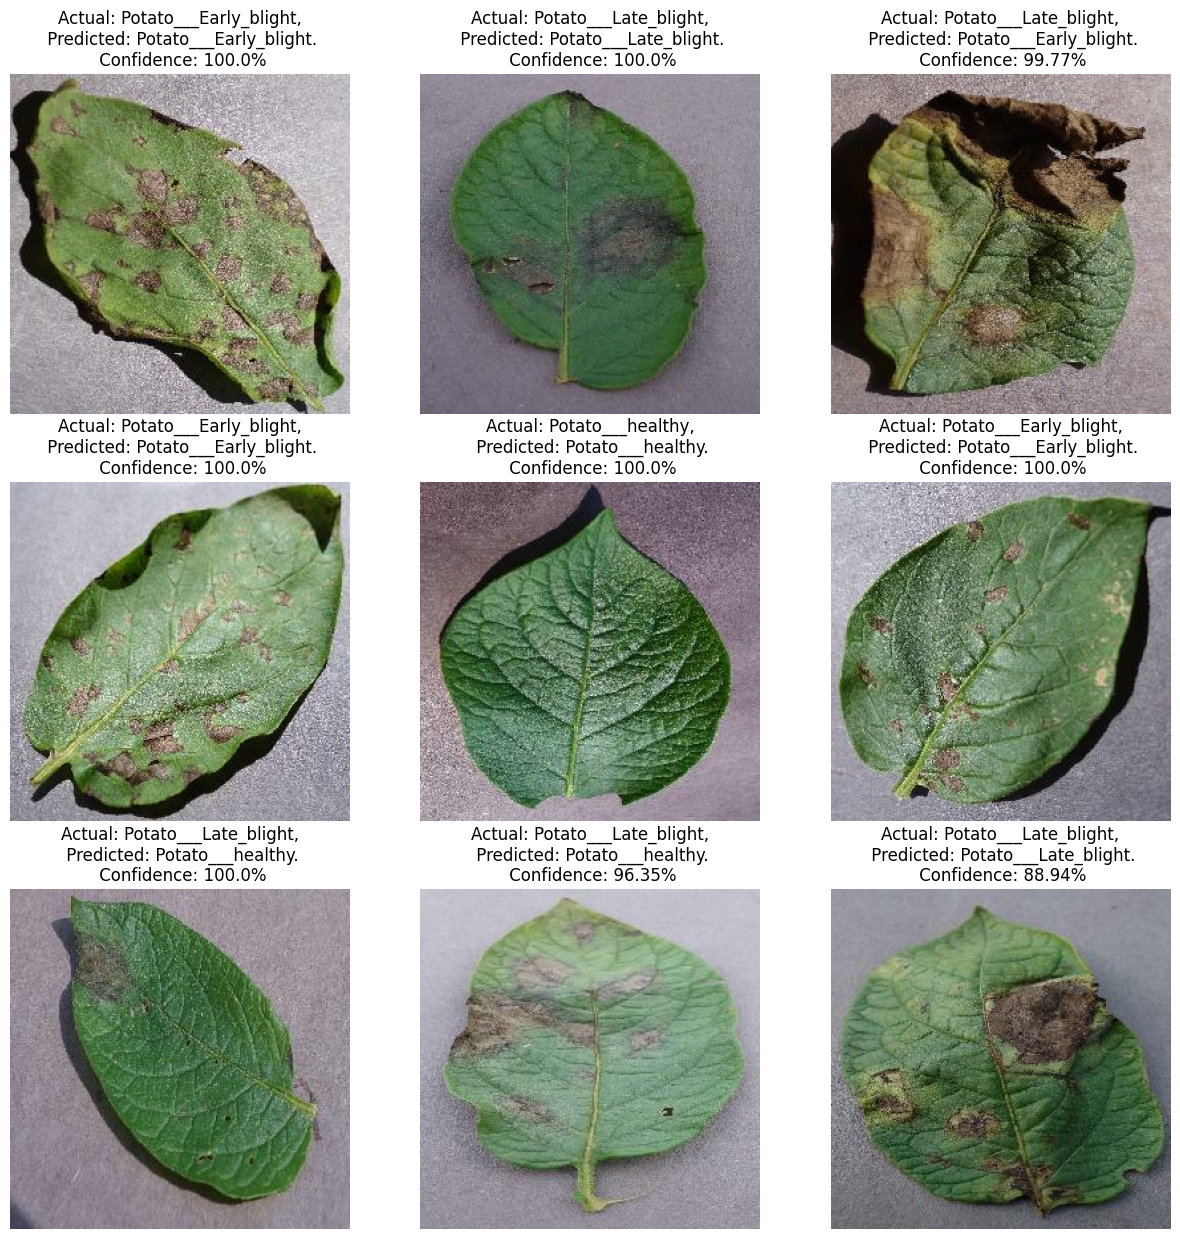

In [132]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../cnn1models") + [0]])+1
model.save(f"../cnn1models/{model_version}")

ValueError: invalid literal for int() with base 10: '.git'

In [52]:
model.save("../cnn1.h5")

C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
